# Example of how to access the ZTF database on Epyc

We capture the nightly ZTF data stream and store it into a database named `ztf` on `epyc.astro.washington.edu` machine. They're all collected in a single table named `alerts`.

Note: this is still a work in progress and more columns will be added in near future.

This notebook gives you a brief demo of how to access the data. The database is on `epyc.astro.washington.edu` and can only be connected to from that machine. It's easiest to use epyc's JupyterHub instance (https://epyc.astro.washington.edu/jupyter) to start notebooks on eypc.

Note: You can find the Jupyter notebook source file on `epyc` at: `/epyc/users/zgolkhou/uw-ztf-database-demo.ipynb`

In [1]:
import pandas as pd
import numpy as np
import mysql.connector as mariadb
from astropy.time import Time
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
pd.set_option('display.max_columns',100)

In [4]:
pd.set_option('float_format', '{:f}'.format)

#### Connecting

Connect to the database using the user `ztf`. There's no password. You *must* do this from epyc (the database is inaccessible outside epyc).

In [5]:
con = mariadb.connect(user='ztf', database='ztf')

After that, it's easiest to use Pandas to execute queries. Below are some examples.

#### Sample 10 rows from the table

In [6]:
%%time

df = pd.read_sql_query('select * from alerts LIMIT 10', con)
df

CPU times: user 133 ms, sys: 25.1 ms, total: 158 ms
Wall time: 181 ms


The descriptions of these columns can be found at https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html.

#### Histogram the number of objects with `nobs` repeated observations

In [7]:
%%time

df = pd.read_sql_query('select count(*) as nobs from alerts GROUP BY objectId', con)

CPU times: user 1min 3s, sys: 7.8 s, total: 1min 11s
Wall time: 1min 2s


<IPython.core.display.Javascript object>


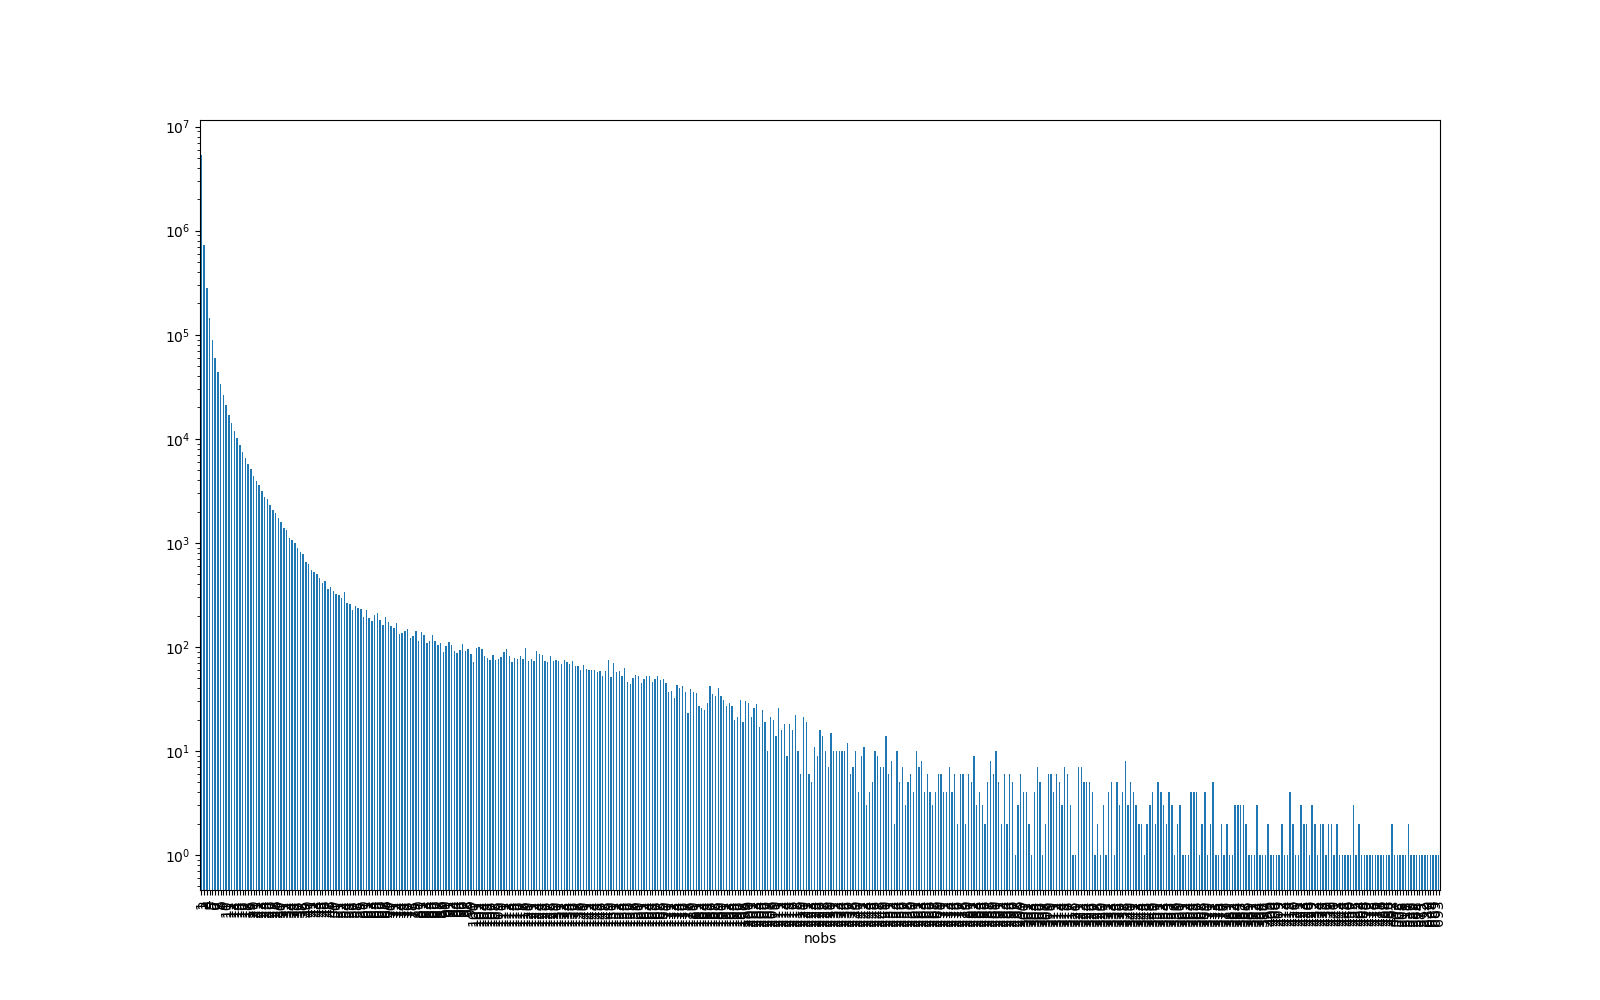

CPU times: user 9.11 s, sys: 1.11 s, total: 10.2 s
Wall time: 1.14 s


In [8]:
%%time

df.groupby('nobs')[['nobs']].count().plot(kind='bar',logy=True, legend=False,fontsize=10, grid=False,\
                                          figsize=(16,10))

<IPython.core.display.Javascript object>


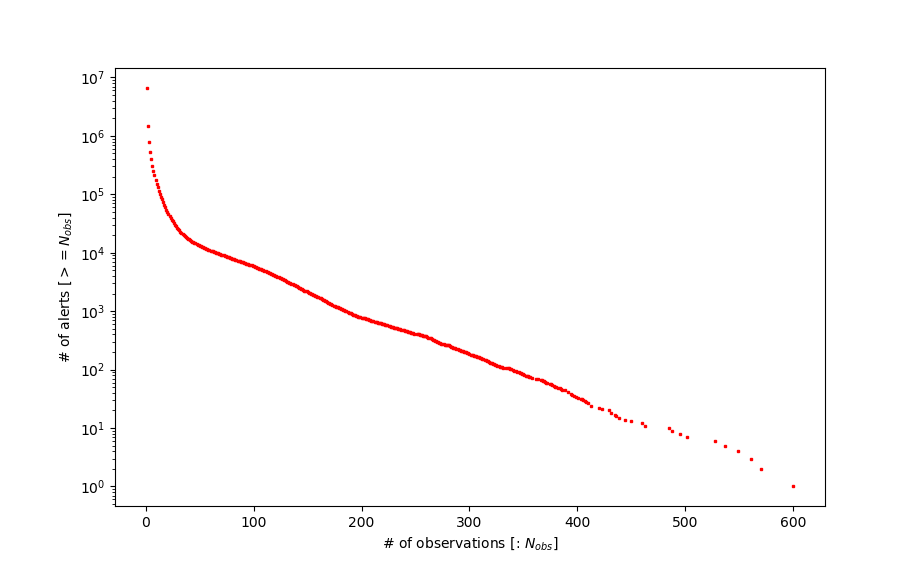

Text(0,0.5,'# of alerts [$>= N_{obs}$]')

In [9]:
csum = df.groupby('nobs')[['nobs']].count()
xax = csum.index
#from numpy import array, cumsum
plt.figure(2)
plt.semilogy(xax[::-1],np.cumsum(np.array(csum[::-1])),'rs',ms=2)
plt.xlabel('# of observations [: $N_{obs}$]')
plt.ylabel(r'# of alerts [$>= N_{obs}$]')
#plt.grid()

#### Time series of an object with a large number of observations

First, get all objects with more than 300 observations.

In [10]:
%%time

interesting = pd.read_sql_query('select objectId, count(*) as nobs from alerts GROUP BY objectId HAVING nobs > 500', con)

CPU times: user 4.01 ms, sys: 4 ms, total: 8.02 ms
Wall time: 6.53 s


In [11]:
interesting.objectId

0    ZTF18aagrhhl
Name: objectId, dtype: object

This function retrieves a light curve from the `alerts` table and the associated upper-limits from the `alerts_limmag` table using objectId.

In [12]:
def retrieve_lc_limmag(objectName):
    
    dflc = pd.read_sql_query("SELECT objectId, jd, magpsf, sigmapsf, diffmaglim ,ra, decl, fid, \
    classtar, rb, candid FROM alerts where objectId='{}' ORDER BY jd".format(objectName), con=con)
    
    dflm = pd.read_sql_query("SELECT objectId, jd, diffmaglim, fid FROM alerts_limmag where objectId='{}' \
    ORDER BY jd".format(objectName), con=con)
    
    return dflc, dflm  

In [13]:
def plot_lightcurve(dflc,dflm, days_ago=True):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        tc = dflc.jd - now
        tm = dflm.jd - now
        xlabel = 'Days Ago'
    else:
        tc = dflc.jd
        tm = dflm.jd
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        
        # plotting detections
        v = (dflc.fid == fid)
        if np.sum(v):
            plt.errorbar(tc[v],dflc.loc[v,'magpsf'], dflc.loc[v,'sigmapsf'],fmt='.',color=color,alpha=0.5)
            
        # plotting upper-limits from the prv_candidate
        w = (dflm.fid == fid)
        if np.sum(w):
            plt.scatter(tm[w],dflm.loc[w,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')

A few objectId's to play with:

In [14]:
%%time

#objId  = 'ZTF18aaavxvj'
objId  = 'ZTF18aagrhhl'
#objId = 'ZTF18aarqyuk'
#objId = 'ZTF18aaqjtcz'
lc, limmag = retrieve_lc_limmag(objId)

CPU times: user 37.4 ms, sys: 14.2 ms, total: 51.6 ms
Wall time: 152 ms


In [15]:
lc.head()

,objectId,jd,magpsf,sigmapsf,diffmaglim,ra,decl,fid,classtar,rb,candid
0,ZTF18aagrhhl,2458216.885394,18.162000,0.044868,20.245000,247.586783,36.832068,2,0.672000,0.513333,462385396115010001
1,ZTF18aagrhhl,2458216.910474,18.088500,0.042837,19.825600,247.586795,36.831941,2,0.969000,0.370000,462410476115010002
2,ZTF18aagrhhl,2458216.910474,18.088500,0.042837,19.825600,247.586769,36.831890,2,0.777000,0.376667,462410476115010003
3,ZTF18aagrhhl,2458219.884225,18.596100,0.056672,20.547400,247.586762,36.832065,2,0.999000,0.533333,465384224815010001
4,ZTF18aagrhhl,2458219.905116,18.356500,0.047248,20.335000,247.586845,36.831983,2,0.996000,0.430000,465405114815010001


In [16]:
limmag.head()

,objectId,jd,diffmaglim,fid
0,ZTF18aagrhhl,2458197.957500,20.921700,2
1,ZTF18aagrhhl,2458198.893194,20.231500,2
2,ZTF18aagrhhl,2458198.893657,20.147000,2
3,ZTF18aagrhhl,2458198.899074,20.358700,2
4,ZTF18aagrhhl,2458198.933681,20.408700,2


<IPython.core.display.Javascript object>


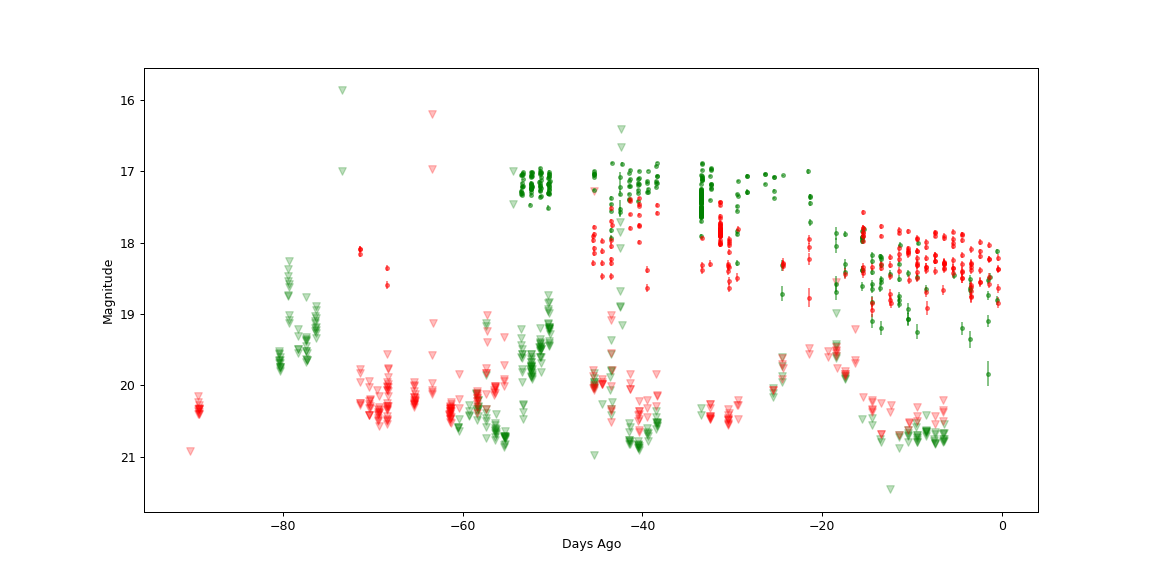

In [17]:
#plot_lightcurve(dflc=lc)
#dflc, dflm = retrieve_limmag('ZTF18aabejqj')
plot_lightcurve(lc,limmag)

Plot the astrometry

<IPython.core.display.Javascript object>


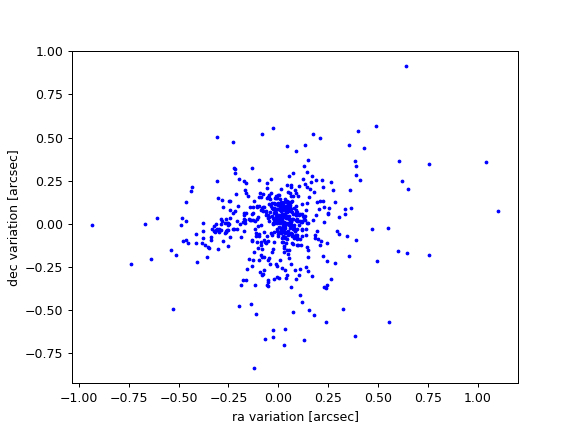

Text(0,0.5,'dec variation [arcsec]')

In [18]:
plt.figure(4)

plt.plot((lc.ra - (lc.ra.mean()))*3600, (lc.decl - (lc.decl.mean()))*3600,'bo',ms=2)

plt.xlabel('ra variation [arcsec]')
plt.ylabel('dec variation [arcsec]')

#### Sanity checks

Note: `the length of unique candid` should be ``=`` `length of dataframe` (: table rows)

In [19]:
df = pd.read_sql_query('select objectid, candid from alerts', con)

In [20]:
len(df.candid.unique())

11793855

In [21]:
len(df)

11793855

In [22]:
len(df.objectid.unique())

6151014